In [2]:
from google.colab import drive
drive.mount('/content/drive')

img_path="/content/drive/MyDrive/image-cap/Images/"
caption_path = "/content/drive/MyDrive/image-cap/captions.txt"

Mounted at /content/drive


In [ ]:
# img_path = "Images/"
# caption_path = "captions.txt"

# Exploring the Flickr8k Dataset

In [3]:
import pandas as pd

df = pd.read_csv(caption_path)
print("Number of image-captions: {}".format(len(df)))
df.head(10)

Number of image-captions: 40455


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


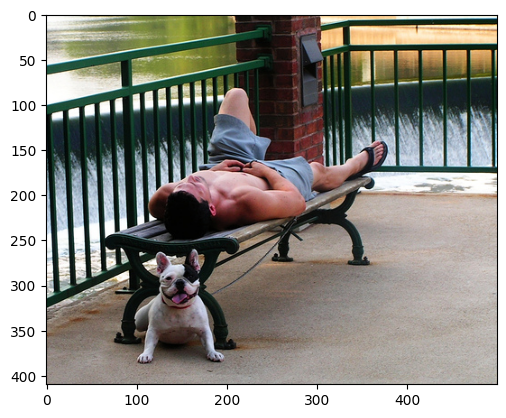

A man lays on a bench while his dog sits by him .
A man lays on the bench to which a white dog is also tied .
a man sleeping on a bench outside with a white and black dog sitting next to him .
A shirtless man lies on a park bench with his dog .
man laying on bench holding leash of dog sitting on ground


In [4]:
#Read the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

idx = 15  #random index to view

img = mpimg.imread(img_path + "/" + df.iloc[idx, 0])
plt.imshow(img)
plt.show()

for i in range(idx, idx + 5):
    print(df.iloc[i, 1])

# Loading The Data

In [5]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import Flickr8k
from torchvision.transforms import v2

transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [6]:
image_data = Flickr8k(root=img_path, ann_file=caption_path, transform=transforms)

In [7]:
image_data

Dataset Flickr8k
    Number of datapoints: 0
    Root location: /content/drive/MyDrive/image-cap/Images/
    StandardTransform
Transform: Compose(
                 RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias=True)
                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
           )

**Using the inbuilt Flickr8k class is not working so I'll try making a custom class**

## Step 1 : Data Preprocessing
### Custom dataset class (Flickr8k)


In [8]:
import os
from collections import Counter
import spacy
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T

from PIL import Image

In [61]:
spacy_eng = spacy.load("en_core_web_sm")

**The Vocabulary class is a helper class to build the vocabulary for the image captions. **

It take a frequency thereshold as input and assigns a numerical token to the word if it appears atleast freq_threshold times.

word_map: a method to map a caption i.e return the numerical token for each word. If the word is unknown it assigns 3 (Unknown)

There are certain tags that need to be padded to the captions:
- < PAD > - We need to pad captions since we want to pass the captions as fixed-length tensor and captions are of varying length
.
- < START > - Marks the start of the sentence
- < END > -  Marks the end of the sentence.


In [10]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<START>", 2: "<END>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}

        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]

    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def word_map(self, text):
        """ For each word in the text map the corresponding index token for that word """
        tokenized_text = self.tokenize(text)
        return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text]

In [11]:
v = Vocabulary(freq_threshold=1)

v.build_vocab(["This is a good place to find a city"])
print(v.stoi)
print(v.word_map("This is a good place to find a city here!!"))

{'<PAD>': 0, '<START>': 1, '<END>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'good': 7, 'place': 8, 'to': 9, 'find': 10, 'city': 11}
[4, 5, 6, 7, 8, 9, 10, 6, 11, 3, 3, 3]


In [17]:
transforms = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [21]:
class FlickrDataset(Dataset):

    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        self.imgs = self.df["image"]
        # print(len(self.imgs))
        self.captions = self.df["caption"]
        # print(len(self.captions))

        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())

        self.max_caption_len = max([len(self.vocab.word_map(caption)) for caption in self.captions])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir, img_name)
        input_image = Image.open(img_location).convert("RGB")

        if self.transform is not None:
            input_tensor = self.transform(input_image)
        input_batch = input_tensor.unsqueeze(0)


        token = self.vocab.word_map(caption)
        token_len = len(token)
        caption_vec = []
        caption_vec += [self.vocab.stoi["<START>"]]
        caption_vec += token
        caption_vec += [self.vocab.stoi["<PAD>"]] * (self.max_caption_len - token_len)
        caption_vec += [self.vocab.stoi["<END>"]]

        return input_tensor, torch.tensor(caption_vec)


Required Input Image format for ResNet

In [22]:
def show_image(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

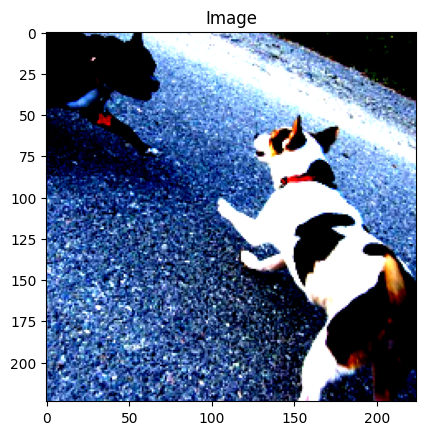

Token: tensor([  1,   4,  20,   6,  16,   4, 680,   6,  34, 694,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2])
Sentence:
['<START>', 'a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<END>']


In [24]:
dataset = FlickrDataset(
    root_dir=img_path,
    captions_file=caption_path,
    transform=transforms
)

img, caps = dataset[5]
show_image(img, "Image")
print("Token:", caps)
print("Sentence:")
print([dataset.vocab.itos[token] for token in caps.tolist()])
# print("probs: ", len(probs))

# Step 2: Encoding the Images using ResNet Model

Applying the concept of transfer learning, we will use an established ResNet model to encode our images.

In [50]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
resnet = nn.Sequential(*list(model.children())[:-1])

In [46]:
# Input - Array of image tensor objects
def encode_image(batch):
  images = []

  for input_tensor in batch:
    images.append(input_tensor)

  images = torch.stack(images) # To create a batch

  if torch.cuda.is_available():
            images = images.to('cuda')
            model.to('cuda')

  with torch.no_grad():
        features = model(images)

  print("output len", len(features))
  return features


In [58]:
# Pass a mini-batch to be encoded
def get_mini_batch(dataset, batch_size):
  mini_batch = []

  for i in range(batch_size):
    img, _ = dataset[i]
    mini_batch.append(img)

  return mini_batch

In [59]:
batch = get_mini_batch(dataset, 4)
output = encode_image(batch)

output len 4


In [60]:
print(output.shape)

torch.Size([4, 1000])


In [ ]:
#Old Code

# if torch.cuda.is_available():
#             input_batch = input_batch.to('cuda')
#             model.to('cuda')
# with torch.no_grad():
#             output = model(input_batch)
# print("output len", len(output))
# print("f", len(output[0]))
# probabilities = torch.nn.functional.softmax(output[0], dim=0)


In [ ]:
# data_loader = DataLoader(
#     dataset=dataset,
#     batch_size=4,
#     num_workers=1,
#     shuffle=True,
# )


# Step 3: Decoding the Images using an LSTM